# Making regional masks for the D5.1

Created by: Stella Bērziņa

Created on: 09.07.2025

## 0) libraries

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import glob
import intake
from pathlib import Path
import dask
import pandas as pd
dask.config.set({"array.slicing.split_large_chunks": True}) 
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
import sys
from numpy import arange, ones

import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.cm import get_cmap
from matplotlib import colors 
from matplotlib.colors import ListedColormap
from matplotlib.figure import Figure
from matplotlib.ticker import FuncFormatter


from datetime import datetime, timedelta
from netCDF4 import Dataset

import io
import os

import warnings
warnings.filterwarnings("ignore")

# from concurrent.futures import ProcessPoolExecutor
# from concurrent.futures import ThreadPoolExecutor

import dask
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,LatitudeLocator)
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point


import tol_colors as tc

## 1) 1 degree mask

In [2]:
field_path = "/work/bk1377/b382618/model_eddy_eval/property_fields_again/"
field_icon = xr.open_dataset(field_path+"icon_all_amplitude.nc")
## this dataset has to have the resolution that you want the mask to have

In [3]:
field_icon = field_icon.amplitude.T
## because pyeddytracker saves the fields transposed

In [9]:
# Extract latitude and longitude
lat = field_icon["y"].values  # Modify based on your file's variable name
lon = field_icon["x"].values

# Create an empty mask array
mask = np.zeros((len(lat), len(lon)), dtype=int)

# Define regions as (lat_min, lat_max, lon_min, lon_max, mask_value)
regions = [
    (30, 65, -170, -110, 1),  # california ebc
    (-40, -15, -110, -70, 1),  # peru/chile ebc?
    (-40, -25, 90, 140, 1),  # australia ebc
    (15, 35, -40, -5, 1),  # N Africa ebc
    (-40, -15, 0, 25, 1),  # S Africa ebc


    (25, 60, -80, -40, 2),  # gulf stream
    (-40, -15, -60, -25, 2),  # S america WBC
    (25, 60, 110, 170, 2),  #  kuroshiro
    (-40, -15, 140, 180, 2),  #  australia wbc

    (-15, 15, -180, 180, 3),  # tropical belt
    (-55, -40, -180, 180, 4),  # SO

    (50, 75, -40, 20, 5),  # NA
]

# Apply masks (Fix broadcasting issue)
for lat_min, lat_max, lon_min, lon_max, mask_value in regions:
    mask[
        (lat[:, None] >= lat_min) & (lat[:, None] <= lat_max) &  # Expand lat
        (lon[None, :] >= lon_min) & (lon[None, :] <= lon_max)    # Expand lon
    ] = mask_value

# Convert to xarray
mask_da = xr.DataArray(mask, coords=[("lat", lat), ("lon", lon)], name="region_mask")
mask_da = xr.where(mask_da == 0, np.nan, mask_da) #replace 0 with nans


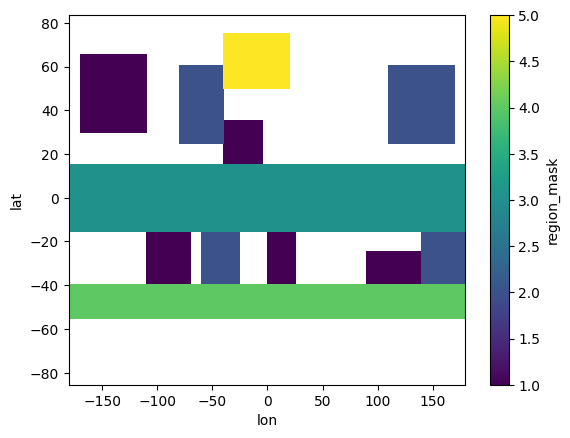

In [7]:
mask_da.plot()

In [8]:
mask_da.to_netcdf("/home/b/b382618/IPYNBS/notebooks_for_d5.1/paper/field_files/" + '1deg_region_mask_eq.nc')


### calculate the area of the regions

In [10]:

# Earth radius (in meters)
R = 6371e3

# Extract lat/lon from the mask
lat = mask_da['lat'].values
lon = mask_da['lon'].values

# Convert degrees to radians
lat_rad = np.deg2rad(lat)

# Compute lat/lon resolution in radians
dlat = np.abs(np.deg2rad(lat[1] - lat[0]))
dlon = np.abs(np.deg2rad(lon[1] - lon[0]))

# Create 2D meshgrid of latitudes
lat_2d, _ = np.meshgrid(lat_rad, lon, indexing='ij')

# Calculate area of each grid cell (m²)
cell_areas = (R**2) * dlat * dlon * np.cos(lat_2d)
cell_areas_da = xr.DataArray(cell_areas, coords=mask_da.coords, dims=mask_da.dims)

# Get region IDs (exclude 0 = land)
region_ids = np.unique(mask_da.values)
region_ids = region_ids[region_ids != 0]  # skip land

# Compute area per region
region_areas = {}
for region_id in region_ids:
    mask = (mask_da == region_id)
    total_area_m2 = cell_areas_da.where(mask).sum().item()
    total_area_km2 = total_area_m2 / 1e6
    region_areas[region_id] = total_area_km2

# Print the result
for region_id, area_km2 in region_areas.items():
    print(f"Region {region_id}: {area_km2:.2f} km²")


Region 1.0: 51269238.44 km²
Region 2.0: 52706940.49 km²
Region 3.0: 136310531.27 km²
Region 4.0: 47958902.54 km²
Region 5.0: 8977420.20 km²
Region nan: 0.00 km²


## 2) 3 degree mask

In [11]:
field_icon = xr.open_dataset("/home/b/b382618/IPYNBS/notebooks_for_d5.1/paper/field_files/"+"hadgemhh25_birth.nc")
## this dataset has to have the resolution that you want the mask to have

In [12]:
field_icon = field_icon["count"].T
## because pyeddytracker saves the fields transposed

In [14]:
# Extract latitude and longitude
lat = field_icon["lat"].values  # Modify based on your file's variable name
lon = field_icon["lon"].values

# Create an empty mask array
mask = np.zeros((len(lat), len(lon)), dtype=int)

# Define regions as (lat_min, lat_max, lon_min, lon_max, mask_value)
regions = [
    (30, 65, -170, -110, 1),  # california ebc
    (-40, -15, -110, -70, 1),  # peru/chile ebc?
    (-40, -25, 90, 140, 1),  # australia ebc
    (15, 35, -40, -5, 1),  # N Africa ebc
    (-40, -15, 0, 25, 1),  # S Africa ebc


    (25, 60, -80, -40, 2),  # gulf stream
    (-40, -15, -60, -25, 2),  # S america WBC
    (25, 60, 110, 170, 2),  #  kuroshiro
    (-40, -15, 140, 180, 2),  #  australia wbc

    (-15, 15, -180, 180, 3),  # tropical belt
    (-55, -40, -180, 180, 4),  # SO

    (50, 75, -40, 20, 5),  # NA

]

# Apply masks (Fix broadcasting issue)
for lat_min, lat_max, lon_min, lon_max, mask_value in regions:
    mask[
        (lat[:, None] >= lat_min) & (lat[:, None] <= lat_max) &  # Expand lat
        (lon[None, :] >= lon_min) & (lon[None, :] <= lon_max)    # Expand lon
    ] = mask_value

# Convert to xarray
mask_da = xr.DataArray(mask, coords=[("lat", lat), ("lon", lon)], name="region_mask")
mask_da = xr.where(mask_da == 0, np.nan, mask_da)
mask_da.to_netcdf("/home/b/b382618/IPYNBS/notebooks_for_d5.1/paper/field_files/" + '3deg_region_mask.nc')


## 3) Mask figure

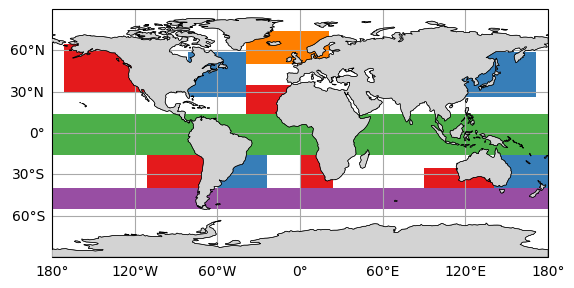

In [17]:
import matplotlib.colors as mcolors

cmap_full = plt.get_cmap("Set1")  # Load the full colormap
selected_colors = [cmap_full(i) for i in range(5)]
cmap = mcolors.ListedColormap(selected_colors)
bounds = np.arange(6)
norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Normalize region values
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})  # Use Plat

# Plot the data layer (rectangles)
g = mask_da.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False)

# Add gridlines
gl = ax.gridlines(draw_labels=True, color="darkgrey")
gl.top_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlabels_top = False
gl.ylabels_right = False

# Set map extent
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add landmask **on top** — make it more visible
ax.add_feature(cfeature.LAND, zorder=10, facecolor="lightgray", edgecolor="black", linewidth=0.3)
ax.add_feature(cfeature.COASTLINE, zorder=11, edgecolor="black", linewidth=0.5)
# plt.show()
# plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/region_map_try3.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
# 

## 4) Mask to exclude the equator

In [ ]:
path = "/home/b/b382615/TO_STELLA/EKE_mean_ICON.nc"
## Aaron made me the eke mean 

In [ ]:
field_icon = xr.open_dataset(path)
field_icon['lon'] = (((field_icon['lon'] + 180) % 360) - 180) # for cartopy i think
field_icon = field_icon.sortby('lon')

In [ ]:
# Extract latitude and longitude
lat = field_icon["lat"].values  # Modify based on your file's variable name
lon = field_icon["lon"].values

# Create an empty mask array
mask = np.zeros((len(lat), len(lon)), dtype=int)

# Define regions as (lat_min, lat_max, lon_min, lon_max, mask_value)
regions = [

    (-5, 5, -180, 180, 3),  # tropical belt

]

# Apply masks (Fix broadcasting issue)
for lat_min, lat_max, lon_min, lon_max, mask_value in regions:c
    mask[
        (lat[:, None] >= lat_min) & (lat[:, None] <= lat_max) &  # Expand lat
        (lon[None, :] >= lon_min) & (lon[None, :] <= lon_max)    # Expand lon
    ] = mask_value

# Convert to xarray
mask_da = xr.DataArray(mask, coords=[("lat", lat), ("lon", lon)], name="region_mask")
mask_da = xr.where(mask_da == 0, np.nan, mask_da)



In [ ]:
mask_da.to_netcdf(field_path + '025deg_equator_mask.nc')
